# Coursework Template

**Dependencies and imports**

This can take a minute...

In [1]:
# !pip install swig
# !pip install --upgrade rldurham

In [2]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [3]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Agent, self).__init__()
        
        # Enhanced policy network with layer normalization for better training stability
        self.policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),  # Add normalization to combat internal covariate shift
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()  # Bound actions to [-1, 1]
        )
        
        # Enhanced value network with separate feature extraction
        self.value_features = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
        )
        
        self.value_head = nn.Linear(hidden_dim, 1)
        
        # Initialize memory buffers
        self.trajectory = []
        self.recent_actions = deque(maxlen=5)  # Store recent actions for smoothing
        
        # Hyperparameters
        self.gamma = 0.99  # Discount factor
        self.learning_rate = 3e-4
        self.gae_lambda = 0.95  # GAE parameter for advantage estimation
        self.clip_ratio = 0.2  # PPO clip ratio
        self.action_std = 0.1  # Initial action noise standard deviation
        self.min_action_std = 0.05  # Minimum exploration noise
        self.action_std_decay = 0.995  # Decay rate for exploration noise
        
        # Separate optimizers for policy and value networks
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        self.value_optimizer = torch.optim.Adam(
            list(self.value_features.parameters()) + list(self.value_head.parameters()), 
            lr=self.learning_rate
        )
        
        # Track statistics
        self.running_rewards = deque(maxlen=100)
        self.value_losses = deque(maxlen=100)
        self.policy_losses = deque(maxlen=100)
        
    def get_value(self, states):
        """Compute state values using the value network"""
        features = self.value_features(states)
        return self.value_head(features)
    
    def sample_action(self, state):
        """
        Sample an action using the policy network with adaptive noise and action smoothing.
        Implements temporal action smoothing for more natural walking motions.
        """
        state = torch.FloatTensor(state)
        with torch.no_grad():
            mean_action = self.policy(state)
            
            # Add exploration noise with adaptive standard deviation
            noise = torch.randn_like(mean_action) * self.action_std
            action = torch.clamp(mean_action + noise, -1, 1)
            
            # Apply temporal action smoothing if we have previous actions
            if len(self.recent_actions) > 0:
                smooth_factor = 0.6
                prev_action = np.mean([a for a in self.recent_actions], axis=0)
                action = torch.FloatTensor(smooth_factor * action.numpy() + 
                                         (1 - smooth_factor) * prev_action)
            
            # Store action for future smoothing
            self.recent_actions.append(action.numpy())
            
        return action.numpy()
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition in trajectory buffer with additional processing"""
        # Add time step to help with temporal credit assignment
        time_step = len(self.trajectory)
        self.trajectory.append((state, action, reward, next_state, done, time_step))
    
    def compute_gae(self, rewards, values, next_values, dones):
        """
        Compute Generalized Advantage Estimation (GAE).
        Provides better advantage estimates for more stable training.
        """
        advantages = []
        gae = 0
        
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = next_values[t]
            else:
                next_value = values[t + 1]
                
            delta = rewards[t] + self.gamma * next_value * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
            advantages.insert(0, gae)
            
        return torch.FloatTensor(advantages)
    
    def train(self):
        """
        Update policy and value networks using collected trajectory.
        Implements PPO-style updates with additional improvements.
        """
        if len(self.trajectory) < 1:
            return
        
        # Unpack trajectory with time steps
        states, actions, rewards, next_states, dones, time_steps = zip(*self.trajectory)
        
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute values and advantages using GAE
        with torch.no_grad():
            values = self.get_value(states).squeeze()
            next_values = self.get_value(next_states).squeeze()
            advantages = self.compute_gae(rewards, values, next_values, dones)
            returns = advantages + values
            
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute action probabilities
        mean_actions = self.policy(states)
        action_log_probs = -0.5 * ((actions - mean_actions) ** 2 / (self.action_std ** 2)).sum(dim=1)
        
        # PPO policy update
        for _ in range(3):  # Multiple epochs of policy optimization
            # Compute new action probabilities
            new_mean_actions = self.policy(states)
            new_action_log_probs = -0.5 * ((actions - new_mean_actions) ** 2 / (self.action_std ** 2)).sum(dim=1)
            
            # Compute probability ratio and clipped objective
            ratio = torch.exp(new_action_log_probs - action_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Update policy network
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
            
            self.policy_losses.append(policy_loss.item())
        
        # Value network update
        for _ in range(3):  # Multiple epochs of value optimization
            values = self.get_value(states).squeeze()
            value_loss = F.mse_loss(values, returns.detach())
            
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(self.value_features.parameters()) + list(self.value_head.parameters()),
                max_norm=0.5
            )
            self.value_optimizer.step()
            
            self.value_losses.append(value_loss.item())
        
        # Decay exploration noise
        self.action_std = max(self.min_action_std, 
                            self.action_std * self.action_std_decay)
        
        # Clear trajectory buffer
        self.trajectory = []
        
        return np.mean(self.policy_losses), np.mean(self.value_losses)
    
    def update_stats(self, episode_reward):
        """Update running statistics with additional metrics"""
        self.running_rewards.append(episode_reward)
        
    def get_average_reward(self):
        """Get average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0
        
    def reset(self):
        """Reset temporal action smoothing between episodes"""
        self.recent_actions.clear()

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


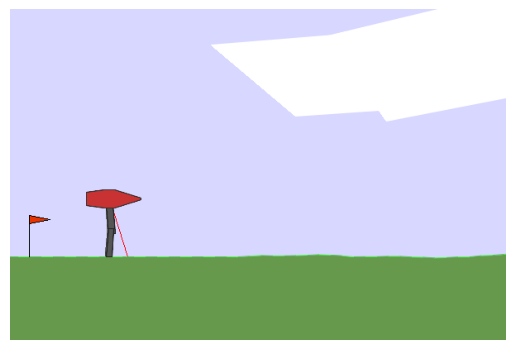

In [4]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

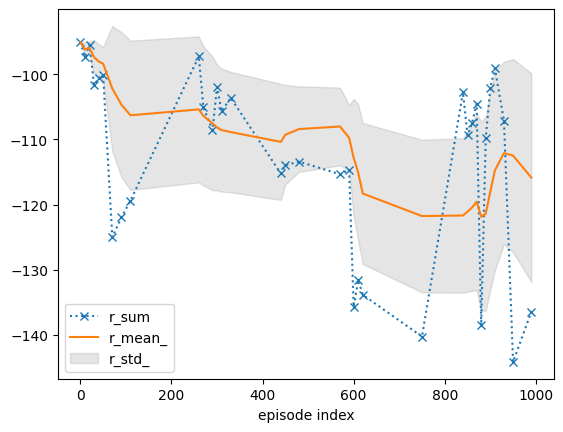

Episode 1000, Reward: -65.36, Avg Reward: -111.21


In [5]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 1000
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# Training procedure
for episode in range(max_episodes):
    
    # Set up recording and tracking flags - every 10th episode
    env.info = episode % 10 == 0   # Track statistics
    env.video = episode % 10 == 0  # Record video
    
    # Reset environment and get initial observation
    observation, info = env.reset()
    episode_reward = 0
    
    # Reset agent's temporal smoothing for new episode
    agent.reset()
    
    # Run episode steps
    for t in range(max_timesteps):
    
        # Get action from agent using current observation
        action = agent.sample_action(observation)
        
        # Execute action in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Add reward to episode total
        episode_reward += reward
        
        # Combine termination conditions
        done = terminated or truncated
        
        # Store transition in agent's memory
        agent.put_data(observation, action, reward, next_observation, done)
        
        # Update observation for next step
        observation = next_observation
        
        # End episode if environment signals done
        if done:
            break
    
    # Train agent using collected experience
    policy_loss, value_loss = agent.train()
    
    # Update agent's statistics with episode results
    agent.update_stats(episode_reward)
            
    # Track and visualize progress
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        # Plot with mean reward, standard deviation, and sum
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
        
        # Print episode information
        print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
              f"Avg Reward: {agent.get_average_reward():.2f}")

# Close environment (ensures final video save)
env.close()

# Write training log file
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [6]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
